In [29]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
import matplotlib.patches as mpatches

## Q-Learning:


\begin{equation*}SuttonBarto : Q(S_t,A_t)\longleftarrow Q(S_t,A_t) + \alpha[R_{t+1}+\gamma max_{a}Q(s_{t+1},a)-Q(S_t,A_t)]
\end{equation*}





In [10]:
class Agent():
    
    def __init__(self, initial_state, world_knowledge):
        self.initial_state = initial_state
        self.current_state = initial_state
        self.knowledge = {(i,j): {} for i in range(N_ROWS) for j in range(N_COLS)}
        self.world_knowledge = world_knowledge
                
        
    def __str__(self) -> str:
        return f'turti at {self.current_state} with knowledge {self.knowledge[self.current_state]}'
    
    
    def change_world_knowledge(self, state, value):
        self.world_knowledge[state] = value
    
    
    def get_next_state(self, base_state, next_action:str)->tuple:
        if next_action == 'Up':
            new_state = (max(base_state[0]-1, 0), base_state[1])
        elif next_action == 'Down':
            new_state = (min(base_state[0]+1, N_ROWS-1), base_state[1])
        elif next_action == 'Left':
            new_state = (base_state[0], max(base_state[1]-1, 0))
        elif next_action == 'Right':
            new_state = (base_state[0], min(base_state[1]+1, N_COLS-1))
        return new_state
    
    
    def get_best_action(self, state):
        
        possible_actions = [a for a in ACTIONS if self.get_next_state(state, a) != state]
        random.shuffle(possible_actions)
        
        # 0? or the value in grid world?
        
        actions = sorted([(a, self.knowledge[state].get(a, 0)) 
                          for a in possible_actions], 
                         key=lambda x: x[1], reverse=True)
        
        # actions[0] if actions else (None, 0)
        
        return actions[0]

    
    
    def calculate_next_action_reward(self, next_state, action):
        
        if next_state==self.current_state:
            return self.knowledge[self.current_state].get(action, 0)
        
        # Current value of the state with the action
        q_a_st = self.knowledge[self.current_state].get(action, 0)
        
        # Max value possible value in the next state # corroborar
        q_max_a_st1 = self.knowledge[next_state].get(self.get_best_action(next_state)[0], 0)
        
        
        q = q_a_st + ALPHA * (self.world_knowledge[next_state] + GAMMA * q_max_a_st1 - q_a_st) 
        
        return q
    
    
    def update_q_knowledge(self):
        for action in ACTIONS:
            next_state = self.get_next_state(self.current_state, action)
            if next_state == self.current_state:
                continue
            self.knowledge[self.current_state][action] = self.calculate_next_action_reward(next_state, action)

    
    def choose_greedy_action(self, epsilon):
        
        if random.random() < epsilon:
            return random.choice(ACTIONS)
        else:
            # best_action, _ = self.get_best_action(self.current_state)
            return self.get_best_action(self.current_state)[0]
    

    def restart(self):
        self.current_state = self.initial_state
        
        
    def epsilon_decay(self, t, decay_rate=0.06):
        return MIN_EPSILON + (1-MIN_EPSILON) * np.exp(-decay_rate*t)
        
            
    def move(self, t):
        
        self.update_q_knowledge()
        
        new_action = self.choose_greedy_action(epsilon=self.epsilon_decay(t))
        
        new_state = self.get_next_state(self.current_state, new_action)
        
        self.current_state = new_state
                
        if (new_state == (0,4)) or (new_state == (0,0)):
            self.restart()
            return self.initial_state
            
        
        return new_state
    
    
N_ROWS = 1
N_COLS = 5
GRID_WORLD = np.zeros((N_ROWS, N_COLS))

GRID_WORLD[(0,4)] = 10
GRID_WORLD[(0,0)] = -10


ACTIONS = ('Left', 'Right')

GAMMA = .9
ALPHA = 0.1
MIN_EPSILON = 0.03

In [11]:
win_state = (0,4)
lose_state = (0,0)

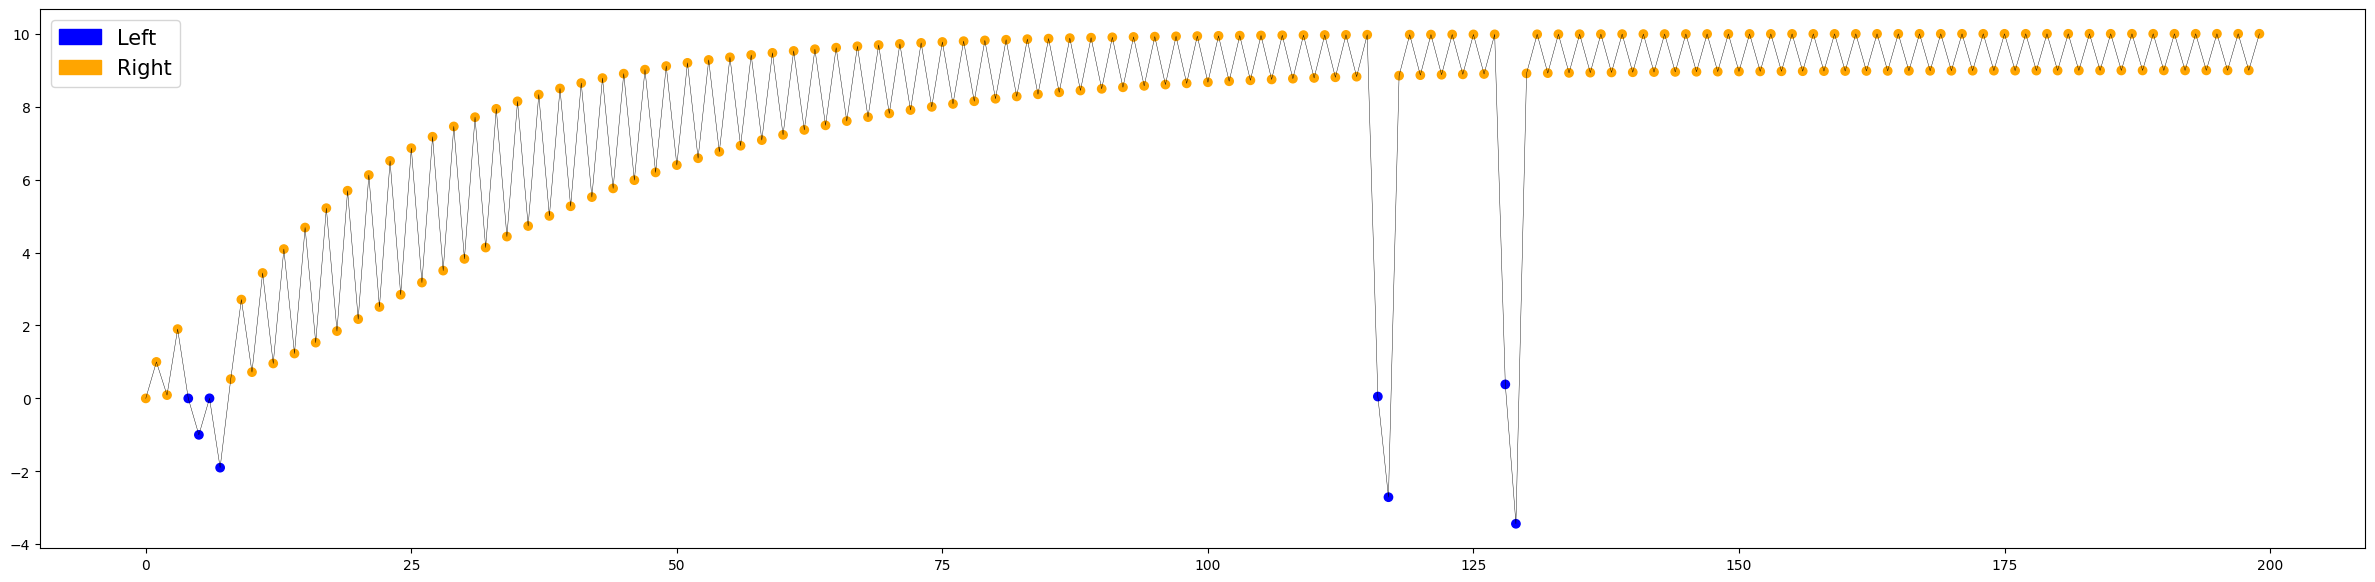

In [41]:
turti = Agent(initial_state=(0,2), world_knowledge=GRID_WORLD.copy())

time = [t for t in range(200)]
moves = []
rewards = []

for t in time:
    
    pos_i = turti.current_state
    turti.move(t=t)
    pos_f = turti.current_state
    
    if (pos_f == (0,2)) and (pos_i == (0,3)):
        action = 'Right'
    elif (pos_f == (0,2)) and (pos_i == (0,1)):
        action = 'Left'
    else:
        action = 'Right' if pos_f[1]-pos_i[1]>0 else 'Left'
    
    reward_obtained = turti.knowledge[pos_i][action]
    
    moves.append(action)
    rewards.append(reward_obtained)
    
    

plt.figure(figsize=(30,7))
plt.scatter(time, rewards, color = ['blue' if m=='Left' else 'orange' for m in moves])
plt.plot(time, rewards, linewidth=0.3, color='k')
# Crear parches para la leyenda
blue_patch = mpatches.Patch(color='blue', label='Left',)
orange_patch = mpatches.Patch(color='orange', label='Right')

# Mostrar la leyenda
plt.legend(handles=[blue_patch, orange_patch], loc='upper left', fontsize=15)
plt.show();

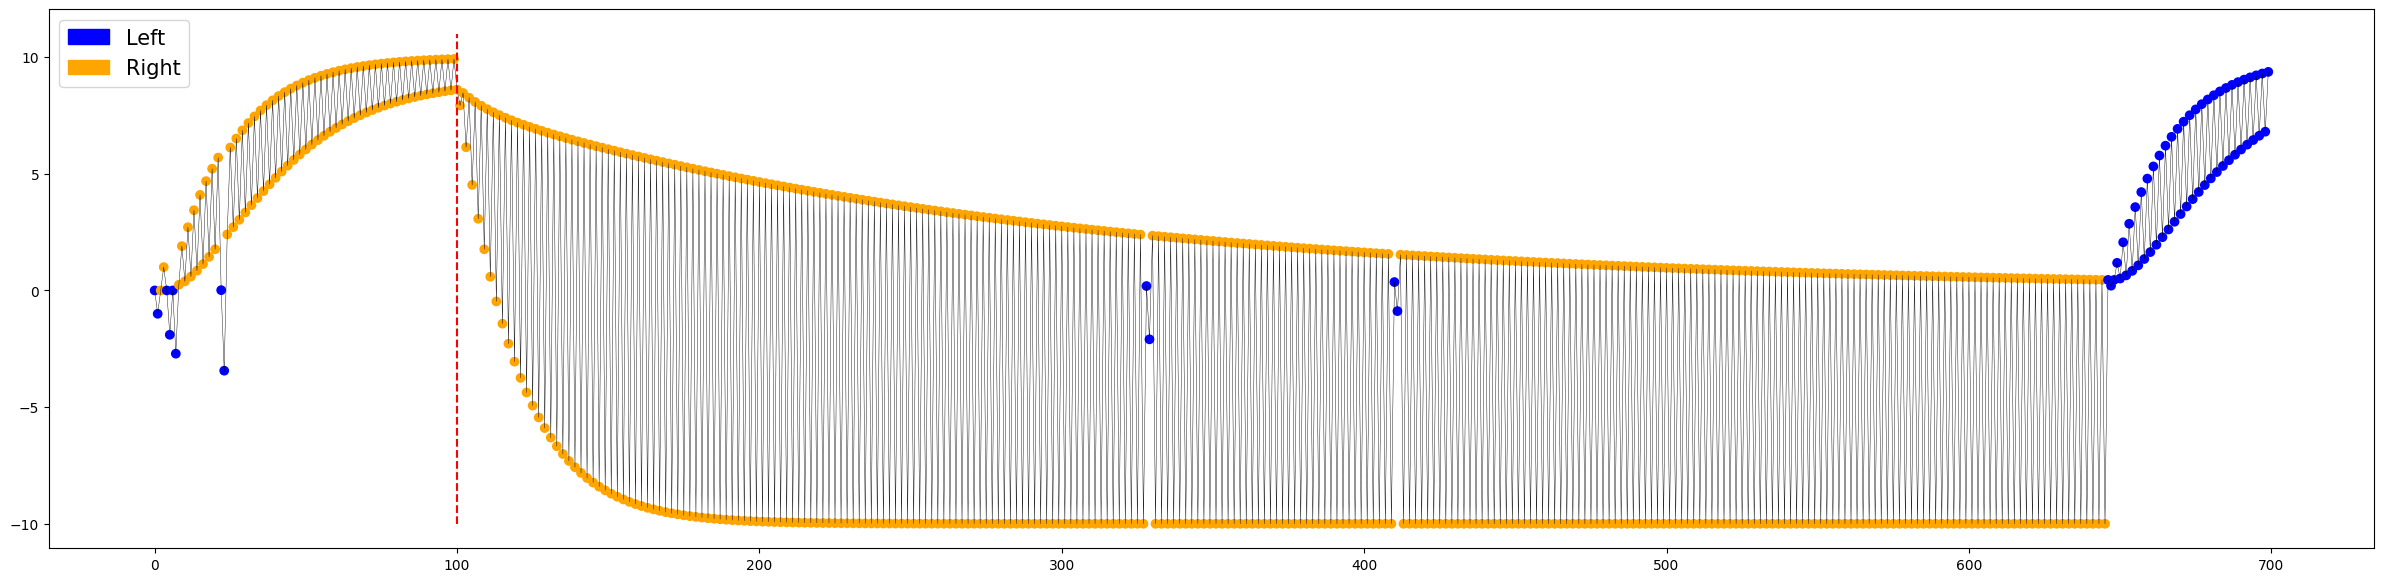

In [42]:
turti = Agent(initial_state=(0,2), world_knowledge=GRID_WORLD.copy())

time = [t for t in range(700)]
moves = []
rewards = []

for t in time:
    
    if t == 100:
        turti.change_world_knowledge((0,4), -10)
        turti.change_world_knowledge((0,0), 10)
    
    pos_i = turti.current_state
    turti.move(t=t)
    pos_f = turti.current_state
    
    if (pos_f == (0,2)) and (pos_i == (0,3)):
        action = 'Right'
    elif (pos_f == (0,2)) and (pos_i == (0,1)):
        action = 'Left'
    else:
        action = 'Right' if pos_f[1]-pos_i[1]>0 else 'Left'
    
    reward_obtained = turti.knowledge[pos_i][action]
    
    moves.append(action)
    rewards.append(reward_obtained)
    
    

plt.figure(figsize=(30,7))
plt.scatter(time, rewards, color = ['blue' if m=='Left' else 'orange' for m in moves])
plt.plot(time, rewards, linewidth=0.3, color='k')
plt.vlines(x=100, ymin=-10, ymax=11, color='r', linestyle='--')
# Crear parches para la leyenda
blue_patch = mpatches.Patch(color='blue', label='Left',)
orange_patch = mpatches.Patch(color='orange', label='Right')

# Mostrar la leyenda
plt.legend(handles=[blue_patch, orange_patch], loc='upper left', fontsize=15)
plt.show();

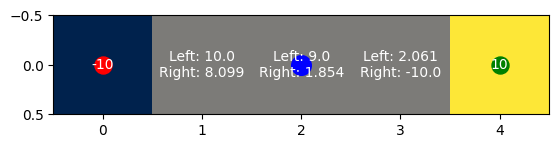

In [28]:
plt.imshow(GRID_WORLD, cmap='cividis', norm='linear')

for i in range(GRID_WORLD.shape[0]):
        for j in range(GRID_WORLD.shape[1]):
            if (j,i)!=(4,0) and (j,i)!=(0,0):
                actions = turti.knowledge[(i,j)]
                actions = '\n'.join([f'{a}: {round(v, 3)}' for a, v in actions.items()])
                plt.text(j, i, f'{actions}', ha='center', va='center', color='white') 

plt.text(0, 0, f'{-10}', ha='center', va='center', color='white')
plt.text(4, 0, f'{10}', ha='center', va='center', color='white')
            
plt.scatter(turti.initial_state[1], turti.initial_state[0], color='b', s=200)

plt.scatter(4, 0, color='g', s=150)
plt.scatter(0, 0, color='r', s=150)

plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


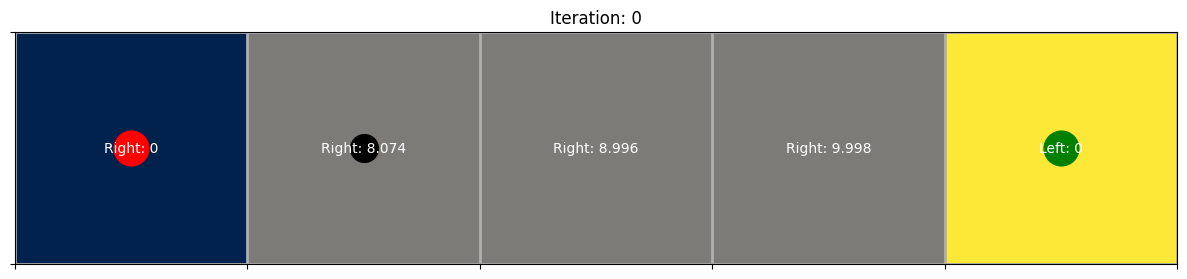

In [84]:
turti = Agent(initial_state=(0,2), world_knowledge=GRID_WORLD.copy())

fig, ax = plt.subplots(figsize=(15, 8))

def update(ite):
    world_knowledge = GRID_WORLD.copy()
    ax.clear()
    ax.set_title(f'Iteration: {ite}')
    ax.imshow(world_knowledge, cmap='cividis')
    
    ax.set_xticks(np.arange(-.5, N_COLS, 1))
    ax.set_yticks(np.arange(-.5, N_ROWS, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.grid(which='both', linewidth=2)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    
    for i in range(world_knowledge.shape[0]):
        for j in range(world_knowledge.shape[1]):
            best_action, value = turti.get_best_action((i,j))
            ax.text(j, i, f'{best_action}: {round(value, 3)}', ha='center', va='center', color='white')        
        
    ax.plot(turti.current_state[1], turti.current_state[0], 'ko', markersize=20)
    
    ax.plot(win_state[1], win_state[0], 'go', markersize=25)
    ax.plot(lose_state[1], lose_state[0], 'ro', markersize=25)
    if ite>0:
        turti.move(t=i)
    return ax

ani = animation.FuncAnimation(fig, update, frames=range(300))
ani.save('simulations/q_learning_clv1.gif', fps=10)

In [6]:
'''
for _ in range(200):
    next_action = turti.choose_action()
    turti.move(next_action)
    
'''

'\nfor _ in range(200):\n    next_action = turti.choose_action()\n    turti.move(next_action)\n    \n'